# This script is to create the ipl_fantasy_dataset from the raw data captured from Kaggel dataset

In [1]:
# import the required libraries
import json
import pandas as pd
import os

In [2]:
def create_ball_by_ball_records(folder_path):
    """
    This function takes location of json file data from cricsheet and return the records containing
    ball by ball match data.
    """
    records = []
    
    # iterate through all json files
    for file_name in os.listdir(folder_path):
        if not file_name.endswith(".json"):
            continue
        match_id = file_name.replace(".json", "")
        file_path = os.path.join(folder_path, file_name)
    
        with open(file_path) as f:
            data = json.load(f)
    
        info = data["info"]
    
        # match-level info
        season = info.get("season")
        match_type = info.get("match_type")
        teams = info.get("teams", [])
        toss_winner = info.get("toss", {}).get("winner")
        toss_decision = info.get("toss", {}).get("decision")
        winner = info.get("outcome", {}).get("winner")
        player_of_match = (info.get("player_of_match")[0] if info.get("player_of_match") else None)
    
        for inning_index, inning in enumerate(data["innings"], start=1):
            batting_team  = inning["team"]
            # bowling team is the other one
            bowling_team = [t for t in teams if t!= batting_team][0]
    
            for over in inning["overs"]:
                over_number = over["over"]+1
                for ball_number, delivery in enumerate(over["deliveries"], start=1):
                    batter = delivery.get("batter")
                    bowler = delivery.get("bowler")
    
                    runs = delivery["runs"]
                    run = runs.get("batter", 0)
                    extras = runs.get("extras", 0)
                    total_runs = runs.get("total", 0)
    
                    is_dismissed = 0
                    dismissal_kind = None
                    fielders = []
                    direct_runout = 0
                    assist_runout = 0
    
                    if "wickets" in delivery :
                        is_dismissed = 1
                        for w in delivery["wickets"]:
                            dismissal_kind = w.get("kind")
                            if "fielders" in w:
                                fielders = [f["name"] for f in w["fielders"]]
                            if dismissal_kind == "run out" and len(fielders) == 1:
                                direct_runout=1
                            if dismissal_kind == "run out" and len(fielders) > 1:
                                assist_runout=1    
                            if dismissal_kind == "caught and bowled":
                                fielders = [bowler]
    
                    records.append({
                        #match level
                        "match_id": match_id,
                        "date": info["dates"][0],
                        "city": info.get("city"),
                        "venue": info.get("venue"),
                        "season": season,
                        "match_type": match_type,
                        "toss_winner": toss_winner,
                        "toss_decision": toss_decision,
                        "winner": winner,
                        "player_of_match": player_of_match,
    
                        # inning-level
                        "innings": inning_index,
                        "batting_team": batting_team,
                        "bowling_team": bowling_team,
    
                        # delivery-level
                        "over": over_number,
                        "ball": ball_number,
                        "batter": batter,
                        "bowler": bowler,
                        "run": run,
                        "extras": extras,
                        "total_runs": total_runs,
                        "is_dismissed": is_dismissed,
                        "dismissal_kind": dismissal_kind,
                        "fielders_involved": ", ".join(fielders) if fielders else None,
                        "is_direct_runout": direct_runout,
                        "is_assist_runout": assist_runout
                    })
    return records

# Path to folder containing all JSON files
folder_path = "data/ipl-fantasy-dataset/ipl_json"
output_csv = "data/ipl-fantasy-dataset/generate/all_matches_deliveries.csv"

# Call the function

data_records = create_ball_by_ball_records(folder_path=folder_path)

# Create dataframe
df = pd.DataFrame(data_records)

# Convert date to datetiem & sort
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(by=["date", "innings"]).reset_index(drop=True)

# Save to CSV
df.to_csv(output_csv, index=False)

print(f" All matched processed. Normalized CSV with inning save at {output_csv}")    

 All matched processed. Normalized CSV with inning save at data/ipl-fantasy-dataset/generate/all_matches_deliveries.csv


## Lets make a dataframe that consist of per match player stats containing batting bowling and fielding details

In [3]:
# download all_matches_deliveries csv
df_deliveries = pd.read_csv("data/ipl-fantasy-dataset/generate/all_matches_deliveries.csv", low_memory=False)
df_deliveries.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278205 entries, 0 to 278204
Data columns (total 25 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   match_id           278205 non-null  int64 
 1   date               278205 non-null  object
 2   city               265808 non-null  object
 3   venue              278205 non-null  object
 4   season             278205 non-null  object
 5   match_type         278205 non-null  object
 6   toss_winner        278205 non-null  object
 7   toss_decision      278205 non-null  object
 8   winner             273503 non-null  object
 9   player_of_match    277399 non-null  object
 10  innings            278205 non-null  int64 
 11  batting_team       278205 non-null  object
 12  bowling_team       278205 non-null  object
 13  over               278205 non-null  int64 
 14  ball               278205 non-null  int64 
 15  batter             278205 non-null  object
 16  bowler             2

In [4]:
# Extract batting performance data by batter
batting = df_deliveries.groupby(['match_id', 'date', 'batter', 'batting_team', 'bowling_team']).agg(
    runs=('run', 'sum'),
    balls_faced=('ball', 'count'),
    fours=('run', lambda x:(x == 4).sum()),
    sixes=('run', lambda x:(x == 6).sum()),
    is_dismissed=('is_dismissed', 'sum'),
    dismissal_kind=('dismissal_kind','sum')
).reset_index()
batting.rename(columns={'batter':'player'}, inplace=True)
batting.rename(columns={'batting_team':'player_team'}, inplace=True)
batting.rename(columns={'bowling_team':'opponent_team'}, inplace=True)
batting['strike_rate'] = round(batting['runs'] / batting['balls_faced'] * 100, 2)

batting.head()

,match_id,date,player,player_team,opponent_team,runs,balls_faced,fours,sixes,is_dismissed,dismissal_kind,strike_rate
0,335982,2008-04-18,AA Noffke,Royal Challengers Bangalore,Kolkata Knight Riders,9,12,1,0,1,run out,75.00
1,335982,2008-04-18,B Akhil,Royal Challengers Bangalore,Kolkata Knight Riders,0,2,0,0,1,caught,0.00
2,335982,2008-04-18,BB McCullum,Kolkata Knight Riders,Royal Challengers Bangalore,158,77,10,13,0,0,205.19
3,335982,2008-04-18,CL White,Royal Challengers Bangalore,Kolkata Knight Riders,6,10,0,0,1,caught,60.00
4,335982,2008-04-18,DJ Hussey,Kolkata Knight Riders,Royal Challengers Bangalore,12,12,1,0,1,caught,100.00


In [5]:
# Extract bowling performance data by bowler
# Step-1 : Find the maiden over delivered by the bowler
maiden_overs = df_deliveries.groupby(['match_id', 'date', 'over', 'bowler']).agg(
    balls_in_over = ('ball', 'count'),
    runs_in_over = ('total_runs', 'sum')
).reset_index()

# Mark maiden overs
maiden_overs['is_maiden'] = (maiden_overs['balls_in_over']==6) & (maiden_overs['runs_in_over']==0)

# Count maidens per bowler
maidens_per_bowler = (
    maiden_overs.groupby(['match_id', 'date', 'bowler'])['is_maiden']
    .sum()
    .reset_index(name='maidens')
)

# Step-2 : Extract the other important data for the bowler
bowling = df_deliveries.groupby(['match_id', 'date', 'bowler', 'bowling_team', 'batting_team']).agg(
    balls_bowled=('ball', 'count'),
    runs_conceded=('total_runs', 'sum'),
    dot_balls=('total_runs', lambda x: (x == 0).sum()),
    wickets=('is_dismissed', lambda x: (x == 1).sum()),
    lbw=('dismissal_kind', lambda x:x.isin(['lbw']).sum()),
    bowled=('dismissal_kind', lambda x:x.isin(['bowled']).sum())

).reset_index()

bowling['overs'] = bowling['balls_bowled'] // 6
bowling['economy'] = round(bowling['runs_conceded'] / bowling['overs'].replace(0, 1), 2)

## Step-3 : merge maidens
bowling = bowling.merge(maidens_per_bowler, on=['match_id', 'date', 'bowler'], how='left')
bowling['maidens'] = bowling['maidens'].fillna(0).astype(int)

bowling.rename(columns={'bowler':'player'}, inplace=True)
bowling.rename(columns={'batting_team':'opponent_team'}, inplace=True)
bowling.rename(columns={'bowling_team':'player_team'}, inplace=True)

bowling.head()

,match_id,date,player,player_team,opponent_team,balls_bowled,runs_conceded,dot_balls,wickets,lbw,bowled,overs,economy,maidens
0,335982,2008-04-18,AA Noffke,Royal Challengers Bangalore,Kolkata Knight Riders,25,41,6,1,0,0,4,10.25,0
1,335982,2008-04-18,AB Agarkar,Kolkata Knight Riders,Royal Challengers Bangalore,28,25,15,3,0,0,4,6.25,0
2,335982,2008-04-18,AB Dinda,Kolkata Knight Riders,Royal Challengers Bangalore,20,9,11,2,0,1,3,3.00,0
3,335982,2008-04-18,CL White,Royal Challengers Bangalore,Kolkata Knight Riders,7,24,0,0,0,0,1,24.00,0
4,335982,2008-04-18,I Sharma,Kolkata Knight Riders,Royal Challengers Bangalore,19,13,10,1,0,1,3,4.33,0


In [6]:
# Extract fielding performance data by fielders involved
# 🔹 Step 1: Split multiple fielders into separate rows
df_expanded = df_deliveries.assign(
    fielders_involved=df_deliveries['fielders_involved'].str.split(',')
).explode('fielders_involved')

# 🔹 Step 2: Clean whitespace (important if "player1, player2" has spaces)
df_expanded['fielders_involved'] = df_expanded['fielders_involved'].str.strip()

fielder = df_expanded.groupby(['match_id', 'date', 'fielders_involved', 'bowling_team', 'batting_team']).agg(
    catches=('dismissal_kind', lambda x:x.isin(['caught', 'caught and bowled']).sum()),
    run_outs=('dismissal_kind', lambda x:(x == 'run out').sum()),
    direct_run_out=('is_direct_runout', lambda x:(x == 1).sum()),
    assist_run_out=('is_assist_runout', lambda x:(x == 1).sum()),
    stumpings=('dismissal_kind', lambda x:x.isin(['stumped']).sum())
).reset_index()

fielder.rename(columns={'fielders_involved':'player'}, inplace=True)
fielder.rename(columns={'bowling_team':'player_team'}, inplace=True)
fielder.rename(columns={'batting_team':'opponent_team'}, inplace=True)
fielder.head()

,match_id,date,player,player_team,opponent_team,catches,run_outs,direct_run_out,assist_run_out,stumpings
0,335982,2008-04-18,AB Agarkar,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,0,1,0
1,335982,2008-04-18,BB McCullum,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0,0,0
2,335982,2008-04-18,CL White,Royal Challengers Bangalore,Kolkata Knight Riders,1,0,0,0,0
3,335982,2008-04-18,JH Kallis,Royal Challengers Bangalore,Kolkata Knight Riders,1,0,0,0,0
4,335982,2008-04-18,M Kartik,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0,0,0


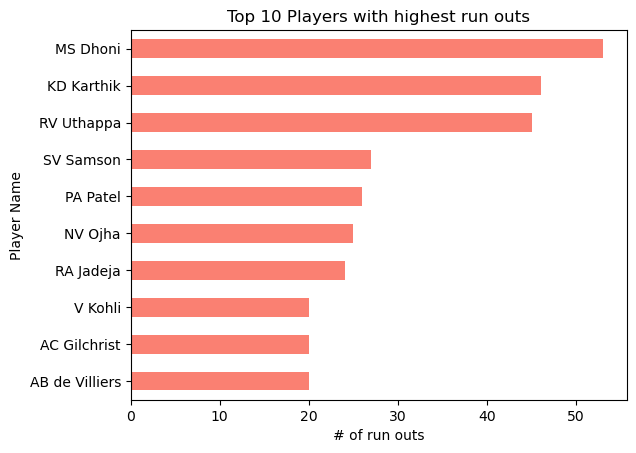

In [7]:
import matplotlib.pyplot as plt
fielding_players = fielder.groupby("player")["run_outs"].sum().sort_values(ascending=False).head(10)
fielding_players.plot(kind='barh', color='salmon')
plt.title("Top 10 Players with highest run outs")
plt.xlabel("# of run outs")
plt.ylabel("Player Name")
plt.gca().invert_yaxis()

In [8]:
# Match information
matches_subset = df_deliveries[['match_id','date','city','venue','season']].drop_duplicates()
matches_subset.head()

,match_id,date,city,venue,season
0,335982,2008-04-18,Bangalore,M Chinnaswamy Stadium,2007/08
225,335984,2008-04-19,Delhi,Feroz Shah Kotla,2007/08
347,335983,2008-04-19,Chandigarh,"Punjab Cricket Association Stadium, Mohali",2007/08
692,335985,2008-04-20,Mumbai,Wankhede Stadium,2007/08
815,335986,2008-04-20,Kolkata,Eden Gardens,2007/08


In [9]:
# merge bowler and batter data
bowler_batter_merge = pd.merge(batting, bowling, on=['match_id', 'date', 'player', 'player_team', 'opponent_team'], how='outer').fillna(0)

# merge bowler, batter and fielder data
player_match_stats = pd.merge(bowler_batter_merge, fielder, on=['match_id', 'date', 'player', 'player_team',  'opponent_team'], how='outer').fillna(0)

# merge bowler, batter, fielder and match data
df_ipl_data = pd.merge(matches_subset, player_match_stats, on=['match_id', 'date'], how='left')

player_match_stats.head().T

,0,1,2,3,4
match_id,335982,335982,335982,335982,335982
date,2008-04-18,2008-04-18,2008-04-18,2008-04-18,2008-04-18
player,AA Noffke,AB Agarkar,AB Dinda,B Akhil,BB McCullum
player_team,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,Royal Challengers Bangalore,Kolkata Knight Riders
opponent_team,Kolkata Knight Riders,Royal Challengers Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore
runs,9.0,0.0,0.0,0.0,158.0
balls_faced,12.0,0.0,0.0,2.0,77.0
fours,1.0,0.0,0.0,0.0,10.0
sixes,0.0,0.0,0.0,0.0,13.0
is_dismissed,1.0,0.0,0.0,1.0,0.0


In [10]:
# Add venue_type column with values Home/Away/neutral
# Normalization map (aliases → standard name)
venue_normalization = {
    "M Chinnaswamy Stadium": "M Chinnaswamy Stadium",
    "M Chinnaswamy Stadium, Bangalore": "M Chinnaswamy Stadium",
    "M Chinnaswamy Stadium, Bengaluru" : "M Chinnaswamy Stadium",
    "M.Chinnaswamy Stadium": "M Chinnaswamy Stadium",
    "Chinnaswamy": "M Chinnaswamy Stadium",
    "Eden Gardens, Kolkata": "Eden Gardens",
    "Eden Gardens": "Eden Gardens",
    "Wankhede Stadium, Mumbai": "Wankhede Stadium",
    "Wankhede Stadium": "Wankhede Stadium",
    "MA Chidambaram Stadium, Chepauk": "MA Chidambaram Stadium",
    "MA Chidambaram Stadium": "MA Chidambaram Stadium",
    "MA Chidambaram Stadium, Chepauk, Chennai": "MA Chidambaram Stadium",
    "Feroz Shah Kotla": "Arun Jaitley Stadium",
    "Arun Jaitley Stadium": "Arun Jaitley Stadium",
    "Arun Jaitley Stadium, Delhi" : "Arun Jaitley Stadium",
    "Sawai Mansingh Stadium, Jaipur": "Sawai Mansingh Stadium",
    "Sawai Mansingh Stadium": "Sawai Mansingh Stadium",
    "Punjab Cricket Association Stadium, Mohali": "Punjab Cricket Association Stadium",
    "Punjab Cricket Association Stadium": "Punjab Cricket Association Stadium",
    "Punjab Cricket Association IS Bindra Stadium, Mohali": "Punjab Cricket Association Stadium",
    "Punjab Cricket Association IS Bindra Stadium" : "Punjab Cricket Association Stadium",
    "Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh": "Punjab Cricket Association Stadium",
    "Maharaja Yadavindra Singh International Cricket Stadium, Mullanpur": "Punjab Cricket Association Stadium",
    "Maharaja Yadavindra Singh International Cricket Stadium, New Chandigarh": "Punjab Cricket Association Stadium",
    "Rajiv Gandhi International Stadium, Uppal": "Rajiv Gandhi International Stadium",
    "Rajiv Gandhi International Stadium": "Rajiv Gandhi International Stadium",
    "Rajiv Gandhi International Stadium, Uppal, Hyderabad": "Rajiv Gandhi International Stadium",
    "Dubai International Cricket Stadium" : "Dubai International Cricket Stadium",
    "Narendra Modi Stadium, Ahmedabad" : "Narendra Modi Stadium",
    "Sardar Patel Stadium, Motera" : "Narendra Modi Stadium",
    "Sheikh Zayed Stadium" : "Sheikh Zayed Stadium",
    "Zayed Cricket Stadium, Abu Dhabi": "Sheikh Zayed Stadium",
    "Sharjah Cricket Stadium":"Sharjah Cricket Stadium",
    "Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium, Lucknow": "BRSABV Ekana Cricket Stadium",
    "Maharashtra Cricket Association Stadium" : "MCA Stadium",
    "Maharashtra Cricket Association Stadium, Pune": "MCA Stadium",
    "Subrata Roy Sahara Stadium": "MCA Stadium",
    "Dr DY Patil Sports Academy, Mumbai" : "DY Patil Stadium",
    "Dr DY Patil Sports Academy": "DY Patil Stadium",
    "Brabourne Stadium, Mumbai": "Brabourne Stadium",
    "Brabourne Stadium" : "Brabourne Stadium",
    "Kingsmead" : "Kingsmead Stadium",
    "Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium" : "ACA–VDCA Cricket Stadium",
    "Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium, Visakhapatnam" : "ACA–VDCA Cricket Stadium",
    "SuperSport Park": "SuperSport Park",
    "Saurashtra Cricket Association Stadium": "Saurashtra Cricket Association Stadium",
    "Himachal Pradesh Cricket Association Stadium" : "HPCA Stadium",
    "Himachal Pradesh Cricket Association Stadium, Dharamsala": "HPCA Stadium",
    "Holkar Cricket Stadium" : "Holkar Cricket Stadium",
    "New Wanderers Stadium": "New Wanderers Stadium",
    "Newlands" : "Newlands Stadium",
    "JSCA International Stadium Complex": "JSCA International Stadium",
    "Barabati Stadium" : "Barabati Stadium",
    "St George's Park": "St George's Park",
    "Shaheed Veer Narayan Singh International Stadium" : "SVNSI Stadium",
    "Barsapara Cricket Stadium, Guwahati": "Barsapara Cricket Stadium",
    "Nehru Stadium" : "Nehru Stadium",
    "Green Park" : "Green Park",
    "Vidarbha Cricket Association Stadium, Jamtha": "Vidarbha Cricket Association Stadium",
    "De Beers Diamond Oval" : "De Beers Stadium",
    "Buffalo Park" : "Buffalo Park Stadium",
    "OUTsurance Oval" : "OUTsurance Oval Stadium"
}

# Normalize team names (aliases → canonical)
team_normalization = {
    "Delhi Daredevils": "Delhi Capitals",
    "Delhi Capitals": "Delhi Capitals",
    "Kings XI Punjab": "Punjab Kings",
    "Punjab Kings": "Punjab Kings",
    "Rising Pune Supergiant": "Rising Pune Supergiants",
    "Rising Pune Supergiants": "Rising Pune Supergiants",
    "Pune Warriors": "Rising Pune Supergiants",
    "Gujarat Lions": "Gujarat Titans",      # historical team
    "Gujarat Titans": "Gujarat Titans",
    "Royal Challengers Bangalore": "Royal Challengers Bangalore",
    "Royal Challengers Bengaluru": "Royal Challengers Bangalore",
    "Kolkata Knight Riders": "Kolkata Knight Riders",
    "Mumbai Indians": "Mumbai Indians",
    "Chennai Super Kings": "Chennai Super Kings",
    "Rajasthan Royals": "Rajasthan Royals",
    "Deccan Chargers": "Sunrisers Hyderabad",  # historical team
    "Sunrisers Hyderabad": "Sunrisers Hyderabad",
    "Lucknow Super Giants": "Lucknow Super Giants",
    "Kochi Tuskers Kerala":"Kochi Tuskers Kerala"
    # add more if new teams/franchise variations appear
}

# Canonical venue → home team mapping
venue_home_map = {
    #Chennai
    "MA Chidambaram Stadium": ["Chennai Super Kings"],

    # Bangalore
    "M Chinnaswamy Stadium": ["Royal Challengers Bangalore"],

    # Kolkata
    "Eden Gardens": ["Kolkata Knight Riders"],

    # Mumbai
    "Wankhede Stadium": ["Mumbai Indians"],
    "DY Patil Stadium" : ["Mumbai Indians"],
    "Brabourne Stadium" : ["Mumbai Indians"],
    
    # Delhi
    "Arun Jaitley Stadium": ["Delhi Capitals"],

    # Hyderabad
    "Rajiv Gandhi International Stadium": ["Sunrisers Hyderabad"],
    
    # Jaipur
    "Sawai Mansingh Stadium": ["Rajasthan Royals"],
    
    # Punjab
    "Punjab Cricket Association Stadium": ["Punjab Kings"],

    # Ahmedabad
    "Narendra Modi Stadium" : ["Gujarat Titans"],

    # Pune
    "MCA Stadium": ["Rising Pune Supergiants", "Chennai Super Kings"],
    
    # Kochi
    "Nehru Stadium": ["Kochi Tuskers Kerala"],

    # Ranchi
    "JSCA International Stadium": ["Kolkata Knight Riders"],

    # Raipur
    "SVNSI Stadium" : ["Delhi Capitals"], 

    # Indore
    "Holkar Cricket Stadium" : ["Punjab Kings"],

    # Dharamsala
    "HPCA Stadium": ["Punjab Kings"],

    # Lucknow
    "BRSABV Ekana Cricket Stadium": ["Lucknow Super Giants"],

    # Guwahati
    "Barsapara Cricket Stadium": ["Rajasthan Royals"],
    
    # Nagpur
    "Vidarbha Cricket Association Stadium": ["Sunrisers Hyderabad", "Punjab Kings"],

    # Cuttack
    "Barabati Stadium": ["Sunrisers Hyderabad", "Kolkata Knight Riders"],

    #Visakhapatnam
    "ACA–VDCA Cricket Stadium" : ["Sunrisers Hyderabad", "Delhi Capitals"],

    #Rajkot
    "Saurashtra Cricket Association Stadium" : ["Gujarat Titans", "Rising Pune Supergiants"],

    #kanpur
    "Green Park":["Gujarat Titans"],

    # UAE (neutral venues, no permanent home team)
    "Dubai International Cricket Stadium": [],
    "Sharjah Cricket Stadium": [],
    "Sheikh Zayed Stadium": [],

    # South Africa (2009 season, all neutral)
    "Newlands Stadium": [],
    "Kingsmead Stadium": [],
    "SuperSport Park": [],
    "St George's Park": [],
    "Buffalo Park Stadium": [],
    "New Wanderers Stadium": [],
    "De Beers Stadium": [],
    "OUTsurance Oval Stadium": []
}

def get_venue_type(row):
    raw_venue = row["venue"]
    venue = venue_normalization.get(raw_venue, raw_venue)
    raw_player_team = row["player_team"]
    player_team = team_normalization.get(raw_player_team, raw_player_team)
    raw_opponent_team = row["opponent_team"]
    opponent_team = team_normalization.get(raw_opponent_team, raw_opponent_team)
    if venue in venue_home_map:
        if player_team in venue_home_map[venue]:
            venue_type = "Home"
        elif opponent_team in venue_home_map[venue]:
            venue_type = "Away"
        else:
            venue_type = "Neutral"
    else:
        venue_type = "Neutral"

    return venue_type

In [11]:
df_ipl_data['venue_type'] = df_ipl_data.apply(get_venue_type, axis=1)

In [12]:
df_ipl_data.head()

,match_id,date,city,venue,season,player,player_team,opponent_team,runs,balls_faced,...,bowled,overs,economy,maidens,catches,run_outs,direct_run_out,assist_run_out,stumpings,venue_type
0,335982,2008-04-18,Bangalore,M Chinnaswamy Stadium,2007/08,AA Noffke,Royal Challengers Bangalore,Kolkata Knight Riders,9.0,12.0,...,0.0,4.0,10.25,0.0,0.0,0.0,0.0,0.0,0.0,Home
1,335982,2008-04-18,Bangalore,M Chinnaswamy Stadium,2007/08,AB Agarkar,Kolkata Knight Riders,Royal Challengers Bangalore,0.0,0.0,...,0.0,4.0,6.25,0.0,0.0,1.0,0.0,1.0,0.0,Away
2,335982,2008-04-18,Bangalore,M Chinnaswamy Stadium,2007/08,AB Dinda,Kolkata Knight Riders,Royal Challengers Bangalore,0.0,0.0,...,1.0,3.0,3.00,0.0,0.0,0.0,0.0,0.0,0.0,Away
3,335982,2008-04-18,Bangalore,M Chinnaswamy Stadium,2007/08,B Akhil,Royal Challengers Bangalore,Kolkata Knight Riders,0.0,2.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,Home
4,335982,2008-04-18,Bangalore,M Chinnaswamy Stadium,2007/08,BB McCullum,Kolkata Knight Riders,Royal Challengers Bangalore,158.0,77.0,...,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,Away


In [13]:
# define the fantasy point calculation logic

# Dream11 T20 Points System
T20_points = {
    "announced" : 4,
    "run" : 1,
    "boundary_bonus" : 1,
    "six_bonus" : 2,
    "30_run_bonus" : 4,
    "half_century_bonus" : 8,
    "century_bonus" : 16,
    "dismissal_for_duck" : -2,
    "wicket" : 25,
    "lbw/bowled_bonus" : 8,
    "3_wicket_haul" : 4,
    "4_wicket_haul" : 8,
    "5_wicket_haul" : 16,
    "maiden" : 12,
    "catch" : 8,
    "3_catch_bonus" : 4,
    "runout(DirectHit/Stumping)" : 12,
    "runout(Catcher/Thrower)" : 6,
    "min_overs_to_be_bowled_for_economy_points" : 2,
    "economy_points" : {
        "<5" : 6,
        ">=5 and <=5.99" : 4,
        ">=6 and <=7" : 2,
        ">=10 and <=11" : -2,
        ">=11.01 and <=12" : -4,
        ">12" : -6 
    },
    "min_balls_to_be_played_for_strikerate_points" : 10,
    "strike_rate_points" : {
        ">170" : 6,
        ">=150.01 and <=170" : 4,
        ">=130 and <=150" : 2,
        ">=60 and <=70" : -2,
        ">=50 and <=59.99" : -4,
        "<50" : -6
    }
}

def calculate_fantasy_points(row):
    batting_fp = 0
    bowling_fp = 0
    fielding_fp = 0
    announced_fp = 0
    
    announced_fp += T20_points["announced"]

    #Batting
    batting_fp += row["runs"]*T20_points["run"]
    batting_fp += row["fours"]*T20_points["boundary_bonus"]
    batting_fp += row["sixes"]*T20_points["six_bonus"]
    if row["runs"]>=100:
        batting_fp += T20_points["century_bonus"]
    elif row["runs"]>=50:
        batting_fp += T20_points["half_century_bonus"]
    elif row["runs"]>=30:
        batting_fp += T20_points["30_run_bonus"]
    if row["is_dismissed"]=="1":
        if row["runs"] == 0:
            batting_fp += T20_points["dismissal_for_duck"]
    if row["balls_faced"]>=T20_points["min_balls_to_be_played_for_strikerate_points"]:
        str_rate = row["strike_rate"]
        for x,y in T20_points["strike_rate_points"].items():
            l = x.split(" and ")
            if len(l)==1:
                if eval(str(str_rate)+l[0]):
                    batting_fp += y
                    break
            else:
                if eval(str(str_rate)+l[0]) and eval(str(str_rate)+l[1]):
                    batting_fp += y
                    break        

    #Bowling
    bowling_fp += row["wickets"]*T20_points["wicket"]
    bowling_fp += row["lbw"]*T20_points["lbw/bowled_bonus"]
    bowling_fp += row["bowled"]*T20_points["lbw/bowled_bonus"]
    if row["wickets"]>=5:
        bowling_fp += T20_points["5_wicket_haul"]
    elif row["wickets"]==4:
        bowling_fp += T20_points["4_wicket_haul"]
    elif row["wickets"]==3:
        bowling_fp += T20_points["3_wicket_haul"]
    bowling_fp += row["maidens"]*T20_points["maiden"]
    if row["overs"]>=T20_points["min_overs_to_be_bowled_for_economy_points"]:
        eco = row["economy"]
        for x,y in T20_points["economy_points"].items():
            l = x.split(" and ")
            if len(l)==1:
                if eval(str(eco)+l[0]):
                    bowling_fp += y
                    break
            else:
                if eval(str(eco)+l[0]) and eval(str(eco)+l[1]):
                    bowling_fp += y
                    break
                    
    #Fielding
    fielding_fp += row["catches"]*T20_points["catch"]
    if row["catches"]>=3:
        fielding_fp += T20_points["3_catch_bonus"]
    fielding_fp += row["direct_run_out"]*T20_points["runout(DirectHit/Stumping)"]
    fielding_fp += row["assist_run_out"]*T20_points["runout(Catcher/Thrower)"]

    total_fp = announced_fp + batting_fp + bowling_fp + fielding_fp
    
    # Create dictionary
    fp_dict = {
        "Announced_FP": announced_fp,
        "Batting_FP": batting_fp,
        "Bowling_FP": bowling_fp,
        "Fielding_FP": fielding_fp,
        "Total_FP": total_fp
    }
    
    return fp_dict

In [14]:
# Apply function and expand dictionary into columns
df_fp = df_ipl_data.apply(lambda row: pd.Series(calculate_fantasy_points(row)), axis=1)

# Combine with original dataframe
df_ipl_data = pd.concat([df_ipl_data, df_fp], axis=1)
df_ipl_data.head()

,match_id,date,city,venue,season,player,player_team,opponent_team,runs,balls_faced,...,run_outs,direct_run_out,assist_run_out,stumpings,venue_type,Announced_FP,Batting_FP,Bowling_FP,Fielding_FP,Total_FP
0,335982,2008-04-18,Bangalore,M Chinnaswamy Stadium,2007/08,AA Noffke,Royal Challengers Bangalore,Kolkata Knight Riders,9.0,12.0,...,0.0,0.0,0.0,0.0,Home,4.0,10.0,23.0,0.0,37.0
1,335982,2008-04-18,Bangalore,M Chinnaswamy Stadium,2007/08,AB Agarkar,Kolkata Knight Riders,Royal Challengers Bangalore,0.0,0.0,...,1.0,0.0,1.0,0.0,Away,4.0,0.0,81.0,6.0,91.0
2,335982,2008-04-18,Bangalore,M Chinnaswamy Stadium,2007/08,AB Dinda,Kolkata Knight Riders,Royal Challengers Bangalore,0.0,0.0,...,0.0,0.0,0.0,0.0,Away,4.0,0.0,64.0,0.0,68.0
3,335982,2008-04-18,Bangalore,M Chinnaswamy Stadium,2007/08,B Akhil,Royal Challengers Bangalore,Kolkata Knight Riders,0.0,2.0,...,0.0,0.0,0.0,0.0,Home,4.0,0.0,0.0,0.0,4.0
4,335982,2008-04-18,Bangalore,M Chinnaswamy Stadium,2007/08,BB McCullum,Kolkata Knight Riders,Royal Challengers Bangalore,158.0,77.0,...,0.0,0.0,0.0,0.0,Away,4.0,216.0,0.0,8.0,228.0


In [15]:
#Arrange the columns to make to more readable
#move season column
cols = df_ipl_data.columns.tolist()
cols.insert(2, cols.pop(cols.index("season")))
df_ipl_data = df_ipl_data[cols]

#move venue_type
cols = df_ipl_data.columns.tolist()
cols.insert(5, cols.pop(cols.index("venue_type")))
df_ipl_data = df_ipl_data[cols]
df_ipl_data.head()

,match_id,date,season,city,venue,venue_type,player,player_team,opponent_team,runs,...,catches,run_outs,direct_run_out,assist_run_out,stumpings,Announced_FP,Batting_FP,Bowling_FP,Fielding_FP,Total_FP
0,335982,2008-04-18,2007/08,Bangalore,M Chinnaswamy Stadium,Home,AA Noffke,Royal Challengers Bangalore,Kolkata Knight Riders,9.0,...,0.0,0.0,0.0,0.0,0.0,4.0,10.0,23.0,0.0,37.0
1,335982,2008-04-18,2007/08,Bangalore,M Chinnaswamy Stadium,Away,AB Agarkar,Kolkata Knight Riders,Royal Challengers Bangalore,0.0,...,0.0,1.0,0.0,1.0,0.0,4.0,0.0,81.0,6.0,91.0
2,335982,2008-04-18,2007/08,Bangalore,M Chinnaswamy Stadium,Away,AB Dinda,Kolkata Knight Riders,Royal Challengers Bangalore,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,64.0,0.0,68.0
3,335982,2008-04-18,2007/08,Bangalore,M Chinnaswamy Stadium,Home,B Akhil,Royal Challengers Bangalore,Kolkata Knight Riders,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0
4,335982,2008-04-18,2007/08,Bangalore,M Chinnaswamy Stadium,Away,BB McCullum,Kolkata Knight Riders,Royal Challengers Bangalore,158.0,...,1.0,0.0,0.0,0.0,0.0,4.0,216.0,0.0,8.0,228.0


In [16]:
# Export IPL dataframe to csv
df_ipl_data.to_csv("data/ipl-fantasy-dataset/generate/ipl_fantasy_data.csv",
             index=False)